In [1]:
!pip install -U transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HF_TOKEN = os.getenv("HF_TOKEN")

In [5]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("google/medgemma-4b-it", use_auth_token=HF_TOKEN)
model = AutoModelForImageTextToText.from_pretrained(
    "google/medgemma-4b-it",
    torch_dtype="auto",
    device_map="auto",
    use_auth_token=HF_TOKEN
)


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/processing_auto.py:273: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [6]:
!pip install transformers accelerate peft pillow einops


In [ ]:
!unzip /content/drive/MyDrive/mhw07-medgemma.zip -d /content/lora_output


In [9]:
from transformers import AutoTokenizer, AutoModelForVision2Seq
from peft import PeftModel

base_model_name = "minigpt4/matgamba-4b"   # example
lora_path = "/content/lora_output/checkpoint-3270"      # your LoRA folder


model = PeftModel.from_pretrained(model, lora_path)


In [17]:
from PIL import Image
import torch

def infer_ms_lesion_rle(model, processor, image_path):
    """
    Inference function that mirrors the exact data format used during fine-tuning.
    """
    # Load image
    img = Image.open(image_path).convert("RGB")

    # Build EXACT SAME MESSAGE STRUCTURE used in training
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text":
                    "[TASK]\n"
                    "You are given a FLAIR MRI slice of the brain. Your task is to identify and segment all "
                    "multiple sclerosis (MS) lesions visible in the image.\n"
                    "Your output must be a pixel-accurate lesion mask encoded in RLE (Run-Length Encoding).\n\n"
                    "[CONTEXT]\n"
                    "MS lesions typically appear as focal or ovoid hyperintense (bright) regions on FLAIR.\n"
                    "Common locations include:\n"
                    "- periventricular white matter\n"
                    "- juxtacortical white matter\n"
                    "- deep white matter\n"
                    "- infratentorial regions\n\n"
                    "Lesions often have irregular boundaries and are brighter than surrounding tissue.\n\n"
                    "[WHAT YOU SHOULD DO]\n"
                    "Identify every region consistent with an MS lesion and output the binary mask in RLE.\n\n"
                    "[OUTPUT FORMAT]\n"
                    "SEGMENTATION_RLE: \"<rle_string>\"\n"
                }
            ]
        }
    ]

    # Convert messages → model prompt (same as training)
    prompt = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False
    )

    # Prepare model inputs
    inputs = processor(
        text=prompt,
        images=[[img]],
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            temperature=0.0
        )

    # Decode
    result = processor.tokenizer.decode(
        output_ids[0],
        skip_special_tokens=True
    ).strip()

    return result


In [18]:
path = "/content/drive/MyDrive/mhw07-patient-slices_updated.zip/Patient-1"

In [19]:
rle = infer_ms_lesion_rle(
    model,
    processor,
    image_path= "/content/patient1_slice12_flair.png"
)

print(rle)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


user




[TASK]
You are given a FLAIR MRI slice of the brain. Your task is to identify and segment all multiple sclerosis (MS) lesions visible in the image.
Your output must be a pixel-accurate lesion mask encoded in RLE (Run-Length Encoding).

[CONTEXT]
MS lesions typically appear as focal or ovoid hyperintense (bright) regions on FLAIR.
Common locations include:
- periventricular white matter
- juxtacortical white matter
- deep white matter
- infratentorial regions

Lesions often have irregular boundaries and are brighter than surrounding tissue.

[WHAT YOU SHOULD DO]
Identify every region consistent with an MS lesion and output the binary mask in RLE.

[OUTPUT FORMAT]
SEGMENTATION_RLE: "<rle_string>"
model
SEGMENTATION_RLE: "13191 2 13446 5 13694 5 13702 5 13950 5 13960 4 14206 5 14701 3 14956 4 15212 4 15469 4 15725 4 31918 4 32174 4 32430 5 32687 4 32943 4 33200 2 40290 3 40546 3 45210 4 45466 4 45722 4 45978 3 46234 2"


In [20]:
import numpy as np

def rle_to_mask(rle_string, height, width):
    """
    Convert RLE string into a binary mask.
    RLE format: "start length start length ..."
    start positions are 1-indexed.
    """
    # Empty mask
    mask = np.zeros(height * width, dtype=np.uint8)

    if rle_string.strip() == "" or rle_string == '"':
        return mask.reshape((height, width))

    # Split into numbers
    rle_numbers = list(map(int, rle_string.split()))
    starts = rle_numbers[0::2]
    lengths = rle_numbers[1::2]

    for s, l in zip(starts, lengths):
        s -= 1  # convert to 0-index
        mask[s:s + l] = 1

    return mask.reshape((height, width))


In [21]:
from PIL import Image

def mask_to_pil(mask):
    """Convert a numpy mask (0/1) into a PIL image."""
    return Image.fromarray((mask * 255).astype(np.uint8))


In [ ]:
mask_img = mask_to_pil(mask)
mask_img.save("mask.png")


AttributeError: 'str' object has no attribute 'astype'

## Local Inference on GPU
Model page: https://huggingface.co/google/medgemma-27b-it

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/medgemma-27b-it)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [ ]:
import os

In [ ]:
"""# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="google/medgemma-27b-it" , token = os.getenv("HF_TOKEN") , max_new_tokens=20000)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
pipe(text=messages)"""

'# Use a pipeline as a high-level helper\nfrom transformers import pipeline\n\npipe = pipeline("image-text-to-text", model="google/medgemma-27b-it" , token = os.getenv("HF_TOKEN") , max_new_tokens=20000)\nmessages = [\n    {\n        "role": "user",\n        "content": [\n            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},\n            {"type": "text", "text": "What animal is on the candy?"}\n        ]\n    },\n]\npipe(text=messages)'

In [ ]:
from PIL import Image
import os

def chat(text, image_paths):

    # Allow a single string or a list of paths
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    # --- Load each image from path as PIL.Image ---
    images = []
    for path in image_paths:
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Image not found: {path}")
        img = Image.open(path).convert("RGB")
        images.append(img)

    # --- Build the multimodal input message ---
    content = [{"type": "image", "image": img} for img in images]
    content.append({"type": "text", "text": text})

    messages = [{"role": "user", "content": content}]

    # --- Send to the model pipeline ---
    return pipe(text=messages)


In [ ]:
#   !wget --continue -O dataset.zip "https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/f6eda4e0-ca67-4b7b-b155-a7d77b9f7396"


In [ ]:
# !mv dataset.zip "/content/drive/MyDrive/mhw07-patient-full.zip"


In [ ]:
!mkdir -p patients
!unzip /content/drive/MyDrive/mhw07-patient-full.zip -d patients

Archive:  /content/drive/MyDrive/mhw07-patient-full.zip
   creating: patients/Patient-49/
  inflating: patients/Patient-49/49-Flair.nii  
  inflating: patients/Patient-49/49-LesionSeg-Flair.nii  
  inflating: patients/Patient-49/49-LesionSeg-T1.nii  
  inflating: patients/Patient-49/49-LesionSeg-T2.nii  
  inflating: patients/Patient-49/49-T1.nii  
  inflating: patients/Patient-49/49-T2.nii  
   creating: patients/Patient-50/
  inflating: patients/Patient-50/50-Flair.nii  
  inflating: patients/Patient-50/50-LesionSeg-Flair.nii  
  inflating: patients/Patient-50/50-LesionSeg-T1.nii  
  inflating: patients/Patient-50/50-LesionSeg-T2.nii  
  inflating: patients/Patient-50/50-T1.nii  
  inflating: patients/Patient-50/50-T2.nii  
   creating: patients/Patient-51/
  inflating: patients/Patient-51/51-Flair.nii  
  inflating: patients/Patient-51/51-LesionSeg-Flair.nii  
  inflating: patients/Patient-51/51-LesionSeg-T1.nii  
  inflating: patients/Patient-51/51-LesionSeg-T2.nii  
  inflating: p

In [ ]:
#we are going to convert the mask to rle , this way the model will predict and will compare predicted vs actual truth ,
#this way the model will actually understand and compute the loss function , medgamma text-img -> text , no image output


In [ ]:
import nibabel as nib
import numpy as np
import cv2
import os

#20 slices in total
# Load the file
initial = "/content/patients/"
output = "/content/output_updated"
os.makedirs(output, exist_ok=True)

for patient_id in range (1,61):

    flair = nib.load(f'{initial}Patient-{patient_id}/{patient_id}-Flair.nii')
    truth = nib.load(f'{initial}Patient-{patient_id}/{patient_id}-LesionSeg-Flair.nii')

    flair_data = flair.get_fdata()
    truth_data = truth.get_fdata()

    num_slices = flair_data.shape[2]

    output_patient = f"{output}/Patient-{patient_id}"
    os.makedirs(output_patient, exist_ok=True)

    for slice_num in range(num_slices):

        slice_img  = flair_data[:, :, slice_num]
        slice_mask = truth_data[:, :, slice_num]

        # -----------------------------
        # ONLY CHANGE IS HERE:
        # Save FLAIR as 16-bit PNG
        # Save MASK as binary uint8 PNG
        # -----------------------------

        # FLAIR → uint16
        slice_img_uint16 = slice_img.astype(np.uint16)
        cv2.imwrite(
            os.path.join(output_patient, f"patient{patient_id}_slice{slice_num}_flair.png"),
            slice_img_uint16
        )

        # MASK → uint8 (binary 0/255)
        slice_mask_uint8 = (slice_mask > 0).astype(np.uint8) * 255
        cv2.imwrite(
            os.path.join(output_patient, f"patient{patient_id}_slice{slice_num}_mask.png"),
            slice_mask_uint8
        )

    print(f"Patient-{patient_id} processed.")


Patient-1 processed.
Patient-2 processed.
Patient-3 processed.
Patient-4 processed.
Patient-5 processed.
Patient-6 processed.
Patient-7 processed.
Patient-8 processed.
Patient-9 processed.
Patient-10 processed.
Patient-11 processed.
Patient-12 processed.
Patient-13 processed.
Patient-14 processed.
Patient-15 processed.
Patient-16 processed.
Patient-17 processed.
Patient-18 processed.
Patient-19 processed.
Patient-20 processed.
Patient-21 processed.
Patient-22 processed.
Patient-23 processed.
Patient-24 processed.
Patient-25 processed.
Patient-26 processed.
Patient-27 processed.
Patient-28 processed.
Patient-29 processed.
Patient-30 processed.
Patient-31 processed.
Patient-32 processed.
Patient-33 processed.
Patient-34 processed.
Patient-35 processed.
Patient-36 processed.
Patient-37 processed.
Patient-38 processed.
Patient-39 processed.
Patient-40 processed.
Patient-41 processed.
Patient-42 processed.
Patient-43 processed.
Patient-44 processed.
Patient-45 processed.
Patient-46 processe

In [ ]:
#!cp -r "/content/output_updated" "/content/drive/MyDrive/mhw07-patient-slices_updated"

In [ ]:
SEGMENTATION_PROMPT = """
[TASK]
You are given a FLAIR MRI slice of the brain. Your task is to identify and segment all multiple sclerosis (MS) lesions visible in the image.
Your output must be a pixel-accurate lesion mask encoded in RLE (Run-Length Encoding).

[CONTEXT]
MS lesions typically appear as focal or ovoid hyperintense (bright) regions on FLAIR.
Common locations include:
- periventricular white matter
- juxtacortical white matter
- deep white matter
- infratentorial regions

Lesions often have irregular or fuzzy boundaries and are brighter than the surrounding white matter, but should not be confused with ventricles, CSF spaces, or cortical gray matter.

[WHAT YOU SHOULD DO]
Analyze the FLAIR slice and identify every region whose appearance is consistent with an MS lesion.
Convert the predicted binary segmentation mask into an RLE string following the standard run-length format.

[OUTPUT FORMAT]
Return your result in the following format only:
SEGMENTATION_RLE: "<rle_string>"

Do not include explanations or descriptions.
Do not describe lesion count or appearance.
Your output must contain only the RLE mask.
"""

In [ ]:

def mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = (pixels > 0).astype(np.uint8)
    padded = np.pad(pixels, (1, 1), mode='constant', constant_values=0)
    diffs = np.diff(padded)
    runs = np.where(diffs != 0)[0]
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

In [ ]:
import os
import cv2
import json

input_root = "/content/output_updated"
jsonl_path = "/content/dataset.jsonl"

# Make sure mask_to_rle and SEGMENTATION_PROMPT are defined
# mask_to_rle(mask) → returns RLE string
# SEGMENTATION_PROMPT → your segmentation instruction prompt

with open(jsonl_path, "w") as jsonl_file:

    # Loop through all patient folders
    for patient_name in sorted(os.listdir(input_root)):

        patient_folder = os.path.join(input_root, patient_name)
        if not os.path.isdir(patient_folder):
            continue

        # Loop through all slices inside each patient
        for filename in sorted(os.listdir(patient_folder)):

            if filename.endswith("_mask.png"):

                mask_path = os.path.join(patient_folder, filename)
                flair_path = mask_path.replace("_mask.png", "_flair.png")

                # Safety check: skip if matching flair slice doesn't exist
                if not os.path.exists(flair_path):
                    print(f"⚠️ Missing FLAIR for mask: {mask_path}")
                    continue

                # Load mask (already uint8)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Convert mask to RLE
                rle = mask_to_rle(mask)

                # Build JSON entry
                entry = {
                    "instruction": SEGMENTATION_PROMPT.strip(),
                    "image": flair_path,          # path to 16-bit PNG
                    "output": f"SEGMENTATION_RLE: \"{rle}\""   # may be empty ""
                }

                # Write to .jsonl
                jsonl_file.write(json.dumps(entry) + "\n")

        print(f"Processed patient: {patient_name}")

print("dataset.jsonl created at:", jsonl_path)


Processed patient: Patient-1
Processed patient: Patient-10
Processed patient: Patient-11
Processed patient: Patient-12
Processed patient: Patient-13
Processed patient: Patient-14
Processed patient: Patient-15
Processed patient: Patient-16
Processed patient: Patient-17
Processed patient: Patient-18
Processed patient: Patient-19
Processed patient: Patient-2
Processed patient: Patient-20
Processed patient: Patient-21
Processed patient: Patient-22
Processed patient: Patient-23
Processed patient: Patient-24
Processed patient: Patient-25
Processed patient: Patient-26
Processed patient: Patient-27
Processed patient: Patient-28
Processed patient: Patient-29
Processed patient: Patient-3
Processed patient: Patient-30
Processed patient: Patient-31
Processed patient: Patient-32
Processed patient: Patient-33
Processed patient: Patient-34
Processed patient: Patient-35
Processed patient: Patient-36
Processed patient: Patient-37
Processed patient: Patient-38
Processed patient: Patient-39
Processed pat

finetuning

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers accelerate peft bitsandbytes pillow einops sentencepiece safetensors


Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.1 MB/s eta 0:00:00


In [ ]:
import os
HF_TOKEN = os.getenv("HF_TOKEN")

In [ ]:
from huggingface_hub import login
login()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("google/medgemma-4b-it", use_auth_token=HF_TOKEN)
model = AutoModelForImageTextToText.from_pretrained(
    "google/medgemma-4b-it",
    torch_dtype="auto",
    device_map="auto",
    use_auth_token=HF_TOKEN
)


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/processing_auto.py:273: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

# Load your JSONL
data = load_dataset(
    "json",
    data_files="/content/dataset.jsonl",
    split="train"
)

# Simple 90/10 split
data = data.train_test_split(test_size=0.1, seed=42)
data["validation"] = data.pop("test")

data


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'image', 'output'],
        num_rows: 1305
    })
    validation: Dataset({
        features: ['instruction', 'image', 'output'],
        num_rows: 146
    })
})

In [ ]:
from PIL import Image

def format_data(example):

    # Load image from path
    img = Image.open(example["image"]).convert("RGB")

    # Build MedGemma-style multimodal messages
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": example["instruction"]},
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": example["output"]},
            ],
        },
    ]

    return example


In [ ]:
print(data["train"][0])


{'instruction': '[TASK]\nYou are given a FLAIR MRI slice of the brain. Your task is to identify and segment all multiple sclerosis (MS) lesions visible in the image.\nYour output must be a pixel-accurate lesion mask encoded in RLE (Run-Length Encoding).\n\n[CONTEXT]\nMS lesions typically appear as focal or ovoid hyperintense (bright) regions on FLAIR.\nCommon locations include:\n- periventricular white matter\n- juxtacortical white matter\n- deep white matter\n- infratentorial regions\n\nLesions often have irregular or fuzzy boundaries and are brighter than the surrounding white matter, but should not be confused with ventricles, CSF spaces, or cortical gray matter.\n\n[WHAT YOU SHOULD DO]\nAnalyze the FLAIR slice and identify every region whose appearance is consistent with an MS lesion.\nConvert the predicted binary segmentation mask into an RLE string following the standard run-length format.\n\n[OUTPUT FORMAT]\nReturn your result in the following format only:\nSEGMENTATION_RLE: "<r

In [ ]:
data = data.map(format_data)


Map:   0%|          | 0/1305 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

In [ ]:
from io import BytesIO
from PIL import Image
from typing import Any

def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []

    for ex in examples:

        # Extract user message
        user_msg = ex["messages"][0]
        user_content = user_msg["content"]

        # Find image block
        image_block = None
        for c in user_content:
            if c["type"] == "image":
                image_block = c["image"]
                break

        if image_block is None:
            raise ValueError("No image found in messages[]")

        # Decode image bytes → PIL Image
        if image_block["bytes"] is not None:
            img_bytes = image_block["bytes"]
            pil_img = Image.open(BytesIO(img_bytes)).convert("RGB")
        else:
            raise ValueError("Image bytes are None")

        # Append nested list (MedGemma requirement)
        images.append([pil_img])

        # Build text prompt using chat template
        text = processor.apply_chat_template(
            ex["messages"],
            add_generation_prompt=False,
            tokenize=False
        ).strip()

        texts.append(text)

    # Process into tensors
    batch = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True
    )

    # Labels for supervised fine-tuning
    labels = batch["input_ids"].clone()

    # Mask padding tokens
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Mask begin-of-image token
    boi_id = processor.tokenizer.convert_tokens_to_ids(
        processor.tokenizer.special_tokens_map["boi_token"]
    )
    labels[labels == boi_id] = -100

    # Mask multimodal separator token
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch


In [ ]:
!pip install trl peft accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 26.0 MB/s eta 0:00:00


In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    task_type="CAUSAL_LM",
)


In [ ]:
from trl import SFTConfig

num_train_epochs = 10
learning_rate = 2e-4

args = SFTConfig(
    output_dir="medgemma-4b-it-sft-ms-lesions",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="steps",
    eval_steps=50,
    learning_rate=learning_rate,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="linear",
    push_to_hub=False,
    report_to="tensorboard",
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,
    label_names=["labels"],
)


In [ ]:
sample = data["train"][0]
batch = collate_fn([sample])

for k, v in batch.items():
    print(k, v.shape)


input_ids torch.Size([1, 788])
attention_mask torch.Size([1, 788])
token_type_ids torch.Size([1, 788])
pixel_values torch.Size([1, 3, 896, 896])
labels torch.Size([1, 788])


In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],  # or subset if too big
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)


The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
trainer.train()
trainer.save_model()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.117000,0.262033,2.458466,178235.000000,0.925531
100,0.192900,0.167878,0.487652,346850.000000,0.937950
150,0.175000,0.160366,0.398056,527416.000000,0.940448
200,0.175600,0.152744,0.397647,711904.000000,0.943044
250,0.157300,0.151004,0.379322,870092.000000,0.944014
300,0.156700,0.149687,0.326827,1044204.000000,0.944128
350,0.176800,0.148228,0.314377,1237211.000000,0.944587
400,0.159000,0.144176,0.453390,1413104.000000,0.946150
450,0.160300,0.144467,0.303073,1588267.000000,0.946052
500,0.141700,0.142768,0.227986,1758098.000000,0.946646


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn



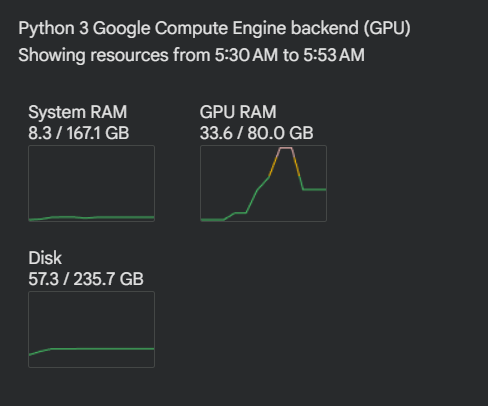

